In [1]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from time import time

# Loda data

In [2]:
batch_size = 26
# resize_num = 299

# Load Data

def get_transforms(train_or_val: str,
                   resize_num):
    return torchvision.transforms.Compose(
        ([torchvision.transforms.RandomResizedCrop(resize_num),
         torchvision.transforms.RandomHorizontalFlip()] if train_or_val == 'train' else 
        [torchvision.transforms.Resize(int(resize_num/224*256)), 
         torchvision.transforms.CenterCrop(resize_num)]) + 
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

class ImageFolderWithName(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        name = os.path.basename(path)
        return image, target, name

model_names = ['vit', 'inception']
data_dir = os.path.join(os.getcwd(),'data/FineGrainDataset')
datasets = {f'{model_name}_{train_or_val}': ImageFolderWithName(root=os.path.join(data_dir, train_or_val),
                                                           transform=get_transforms(train_or_val=train_or_val,
                                                            resize_num=299 if model_name=='inception' else 224)) 
            for model_name in model_names for train_or_val in ['train', 'val']}

assert all(datasets[f'{model_name}_train'].classes == datasets[f'{model_name}_val'].classes 
           for model_name in model_names)

loaders = {f'{model_name}_{train_or_val}': DataLoader(datasets[f'{model_name}_{train_or_val}'], 
                                                 batch_size=batch_size, 
                                                 shuffle=True) 
           for model_name in model_names for train_or_val in ['train', 'val']}

classes = datasets['vit_train'].classes
classes

['2S19_MSTA',
 '30N6E',
 'BM-30',
 'BMD',
 'BMP-1',
 'BMP-2',
 'BMP-T15',
 'BRDM',
 'BTR-60',
 'BTR-70',
 'BTR-80',
 'D-30',
 'Iskander',
 'MT_LB',
 'Pantsir-S1',
 'Rs-24',
 'T-14',
 'T-62',
 'T-64',
 'T-72',
 'T-80',
 'T-90',
 'TOS-1',
 'Tornado']

In [3]:
n = len(classes)
n

24

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

# Model

In [5]:
class InceptionModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(InceptionModel, self).__init__()
        self.inception = torchvision.models.inception_v3(
            weights=torchvision.models.Inception_V3_Weights.DEFAULT)
        num_features = self.inception.fc.in_features
        self.inception.fc = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.inception(x)
        return x

class VITModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(VITModel, self).__init__()
        self.vit = torchvision.models.vit_l_32(weights=torchvision.models.ViT_L_32_Weights.DEFAULT)
        num_features = self.vit.heads[-1].in_features
        self.fc = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.vit(x)
        x = self.fc(x)
        return x

vit_model = VITModel(num_classes=n)
inception_model = InceptionModel(num_classes=n)

# Train

In [ ]:
for model in [vit_model]:
    model_name = model.__class__.__name__.split('Model')[0].lower()
    train_loader = loaders[f'{model_name}_train']
    
    
    criterion = torch.nn.CrossEntropyLoss()
    lr = 0.001
    optimizer = torch.optim.Adam(params=model.parameters(), 
                                 lr=lr)
    scheduler_step_size = 7
    scheduler_gamma = 0.1
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                                step_size=scheduler_step_size,
                                                gamma=scheduler_gamma)
    train_loss = []
    train_acc = []
    train_precision = []
    train_recall = []
    prediction = []
    ground_truth = []
    model.to(device)
    
    num_epochs = 25
    
    for epoch in range(num_epochs):
        t1 = time()
        running_loss = 0.0
        prediction = []
        ground_truth = []
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs[0], labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
            _, predicted = torch.max(outputs[0], 1)
            ground_truth += labels.tolist()
            prediction += predicted.tolist()
    
        print(f'Model: {model_name} '
              f'Epoch {epoch + 1}/{num_epochs} done in {time() - t1} sec, '
              f'\nloss: {round(running_loss / len(train_loader),3)}')
        true_labels = np.array(ground_truth)
        predicted_labels = np.array(prediction)
        acc = accuracy_score(true_labels, predicted_labels)
        print(f'accuracy: {round(acc, 3)}')
        train_acc.append(acc)
        train_loss.append(running_loss / len(train_loader))
        scheduler.step()
        print()

    np.save(f'{model_name}_train_acc.npy', train_acc)
    np.save(f'{model_name}_train_loss.npy', train_loss)

## Train Loss

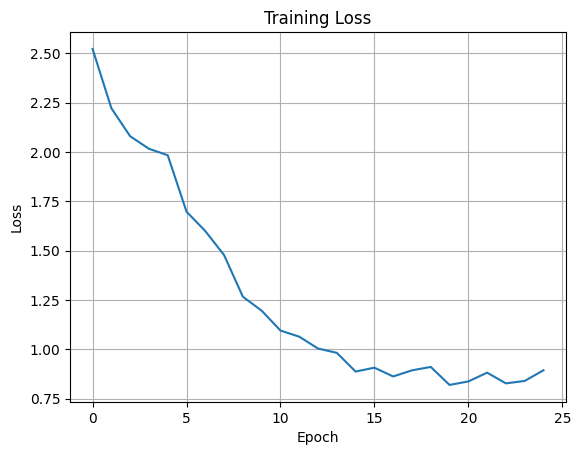

In [5]:
for model in [inception_model]:
    train_loss = np.load(f'{model.__class__.__name__}_train_loss.npy')
    
    plt.plot(train_loss, label='Training Loss')
    plt.grid()
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss');

## Train Accuracy

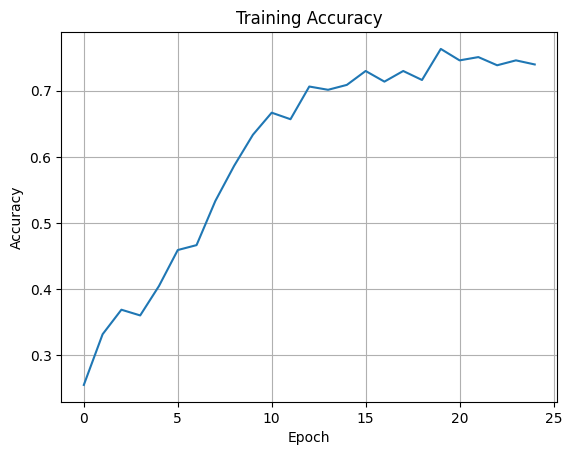

In [6]:
train_acc = np.load('train_acc.npy')

plt.plot(train_acc, label='Training Accuracy')
plt.grid()
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

# Test

In [7]:
model.eval()
correct = 0
total = 0
prediction = []
ground_truth = []
name_list = []

with torch.no_grad():
    for i, data in enumerate(test_loader):
        pred_temp = []
        truth_temp = []
        name_temp = []
        images, labels, names = data[0].to(device), data[1].to(device), data[2] 
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        ground_truth += labels.tolist()
        prediction += predicted.tolist()
        name_list += names # Collect the name values
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_temp += predicted.tolist()
        truth_temp += labels.tolist()
        name_temp += names

print(f'Accuracy of the network on {total} test images is '
      f'{round(accuracy_score(y_true=ground_truth, y_pred=prediction), 4)}')

Accuracy of the network on 236 test images is 0.6822


In [51]:
print(classification_report(ground_truth, prediction, target_names=classes))

                          precision    recall  f1-score   support

             Air Defense       0.87      0.93      0.90        14
                     BMD       0.80      0.73      0.76        22
                     BMP       0.86      0.98      0.92        58
                     BTR       0.96      0.79      0.87        34
                   MT_LB       0.91      0.95      0.93        21
Self Propelled Artillery       0.90      0.69      0.78        26
                    Tank       0.88      0.93      0.90        61

                accuracy                           0.88       236
               macro avg       0.88      0.86      0.87       236
            weighted avg       0.88      0.88      0.88       236


In [60]:
cm = confusion_matrix(y_true=ground_truth, y_pred=prediction)
print(cm)

[[13  0  0  0  0  0  1]
 [ 0 16  4  1  0  1  0]
 [ 0  0 57  0  1  0  0]
 [ 0  3  1 27  1  1  1]
 [ 1  0  0  0 20  0  0]
 [ 1  0  1  0  0 18  6]
 [ 0  1  3  0  0  0 57]]


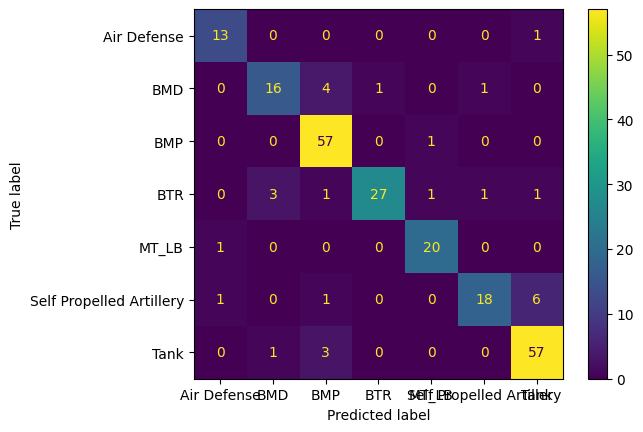

In [63]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=classes)

cm_display.plot()
plt.show()